In [3]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

In [17]:
# read in 2018 songs
songs_df = pd.read_csv('data/songs_10000.csv')
songs_df.head()

,Unnamed: 0,Artist,Track Name,Track ID,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,90,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,1,Lil Baby,Drip Too Hard (Lil Baby & Gunna),78QR3Wp35dqAhFEc2qAGjE,86,0.08520,0.897,145543,0.662,0.000000,1,0.5340,-6.903,0,0.2920,112.511,4,0.389
2,2,Travis Scott,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,89,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446
3,3,Juice WRLD,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,88,0.34900,0.511,239836,0.566,0.000000,6,0.3400,-7.230,0,0.2000,83.903,4,0.218
4,4,YNW Melly,Murder On My Mind,7eBqSVxrzQZtK2mmgRG6lC,86,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740


In [18]:
# drop additional index column
songs_df = songs_df.drop(columns = 'Unnamed: 0')

# calculate summary statistics
display(songs_df.describe())

# print out variable types
print(songs_df.dtypes)

,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,58.874600,0.303989,0.634328,200119.502900,0.573902,0.120668,5.307600,0.176829,-8.25150,0.612700,0.120497,119.849287,3.907800,0.440162
std,7.808775,0.307698,0.172954,58370.598685,0.223470,0.287823,3.614732,0.136660,5.49679,0.487158,0.119886,30.873220,0.433495,0.234605
min,46.000000,0.000002,0.000000,31200.000000,0.000020,0.000000,0.000000,0.019600,-44.56900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,0.041775,0.529000,169272.000000,0.438000,0.000000,2.000000,0.099000,-9.35150,0.000000,0.040300,94.973750,4.000000,0.253000
50%,57.000000,0.183000,0.657000,198643.000000,0.593000,0.000002,5.000000,0.120000,-6.79250,1.000000,0.064200,119.986000,4.000000,0.424500
75%,63.000000,0.512000,0.761000,228000.000000,0.739000,0.002010,8.000000,0.205000,-5.10200,1.000000,0.161000,141.987000,4.000000,0.611250
max,90.000000,0.996000,0.985000,688742.000000,0.998000,1.000000,11.000000,0.979000,0.17500,1.000000,0.966000,220.099000,5.000000,0.981000


Artist               object
Track Name           object
Track ID             object
Popularity            int64
Acousticness        float64
Danceability        float64
Duration_ms           int64
Energy              float64
Instrumentalness    float64
Key                   int64
Liveness            float64
Loudness            float64
Mode                  int64
Speechiness         float64
Tempo               float64
Time Signature        int64
Valence             float64
dtype: object


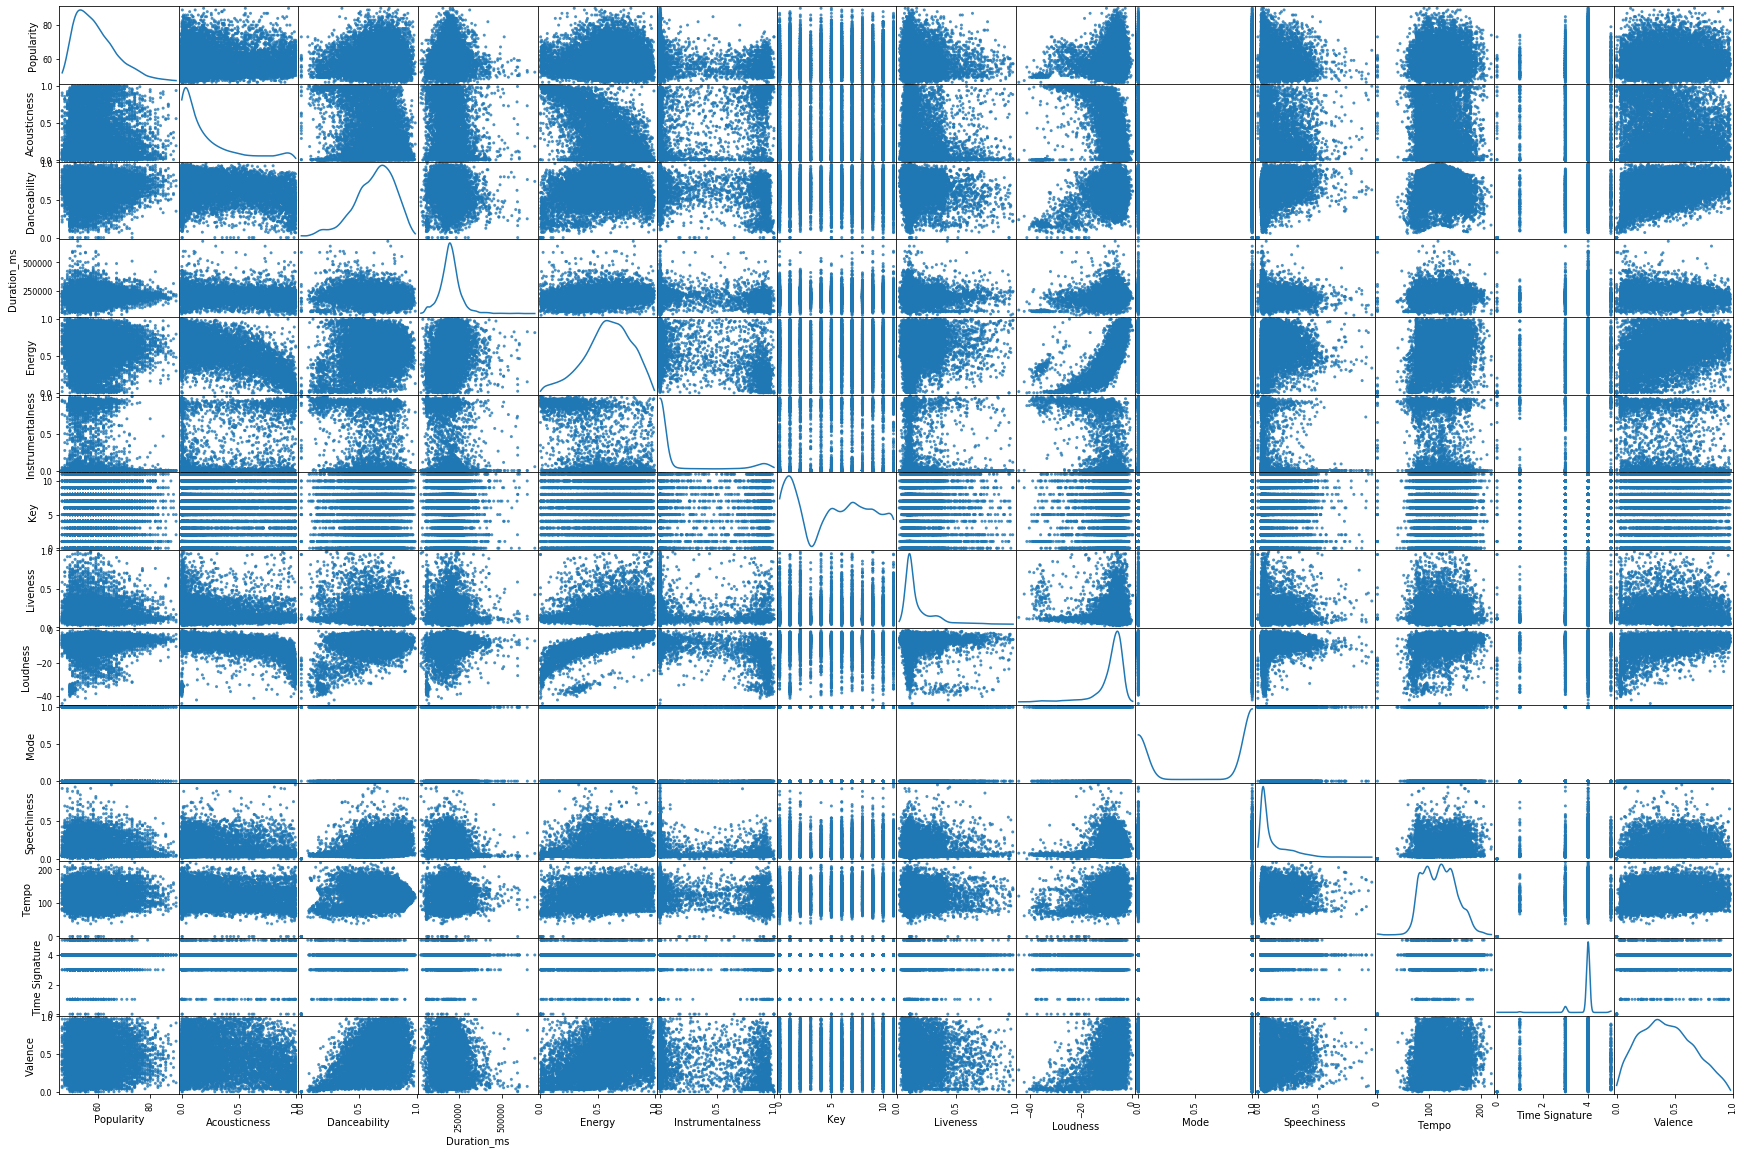

In [27]:
# matrix of pairwise scatterplots
scatter_matrix(songs_df, alpha = 0.8, figsize = (30, 20), diagonal = 'kde')

In [6]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)

In [7]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

In [8]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

In [9]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

Best depth: 3
Classification accuracy on training set: 0.645
Classification accuracy on test set: 0.6395
